In [6]:
import math

In [7]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if  isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float"
        out = Value(self.data ** other, (self, ), f"**{other}")

        def _backward():
            self.grad += other * (self.data**(other - 1)) * out.grad
        
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1
    
    def __rtruediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return self + (-other)
    
    def __radd__(self, other):
        return self + other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
            
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
            
        out._backward = _backward
        
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [8]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
a, b

(Value(data=2.0), Value(data=-3.0))

In [9]:
a+1, 1+a, b+1, 1+b

(Value(data=3.0), Value(data=3.0), Value(data=-2.0), Value(data=-2.0))

In [10]:
a-1, 1-a, b-2, 2-b

(Value(data=1.0), Value(data=1.0), Value(data=-5.0), Value(data=-5.0))

In [11]:
a*2, 2*a, b*2, 2*b

(Value(data=4.0), Value(data=4.0), Value(data=-6.0), Value(data=-6.0))

In [12]:
a/2, 2/a, b/3, 3/b

(Value(data=1.0), Value(data=1.0), Value(data=-1.0), Value(data=-1.0))

In [13]:
k = a+b; k.label='k'
k, k._prev, k._op, k.label

(Value(data=-1.0), {Value(data=-3.0), Value(data=2.0)}, '+', 'k')

In [14]:
k = a*b
k, k._prev, k._op

(Value(data=-6.0), {Value(data=-3.0), Value(data=2.0)}, '*')

In [15]:
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
d, d._prev, d._op

(Value(data=4.0), {Value(data=-6.0), Value(data=10.0)}, '+')

In [16]:
f = Value(-2.0, label='f')
L = d * f; L.label='L'
L

Value(data=-8.0)

In [17]:
from graphviz import Digraph

def trace(root):
    #builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any  value in graph create a rantangular ('record') node for it
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is result of some operation then create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    
    return dot

In [18]:
n = L.tanh()

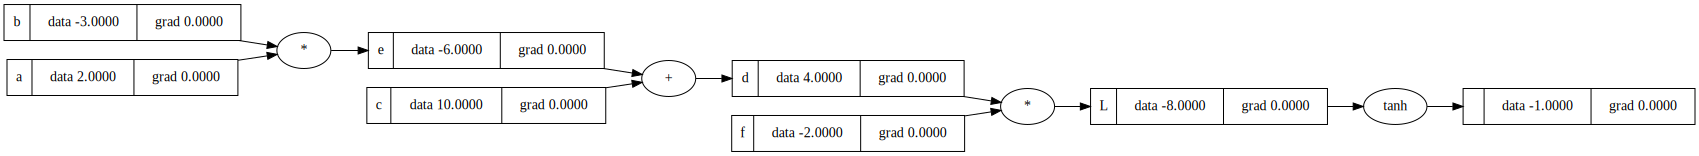

In [19]:
draw_dot(n)

In [20]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.88137, label='b')

# x1*w1 + x2*w2 + b 
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

In [21]:
o.backward()

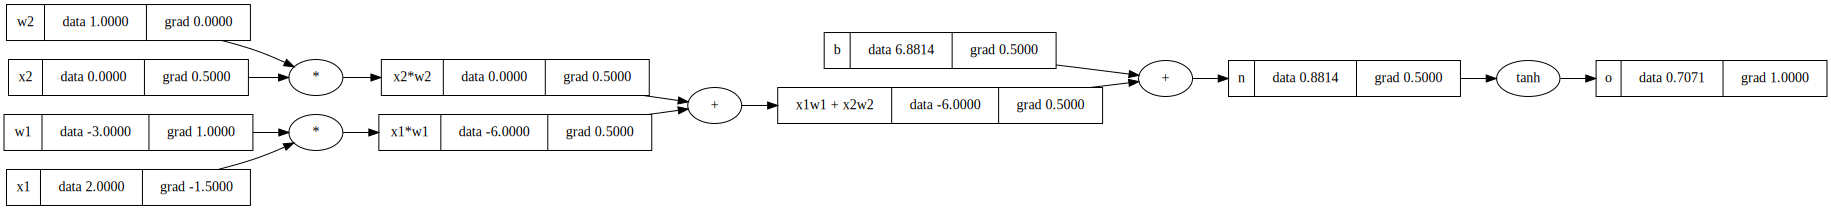

In [22]:
draw_dot(o)